# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [207]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [208]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [209]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [210]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [211]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [213]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?
from torch.optim.lr_scheduler import StepLR
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size=2, gamma=1):    
    loss_history = []
    train_history = []
    val_history = []
    
    scheduler = StepLR(optimizer, step_size, gamma)
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    
        scheduler.step()
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x,y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    acc = float(correct_samples) / total_samples
        
    return acc

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.343786, Train accuracy: 0.632990, Val accuracy: 0.640229
Average loss: 1.331765, Train accuracy: 0.640941, Val accuracy: 0.635042
Average loss: 1.324829, Train accuracy: 0.645668, Val accuracy: 0.639342


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [215]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),            
            nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.190787, Train accuracy: 0.190595, Val accuracy: 0.216163
Average loss: 2.027304, Train accuracy: 0.264239, Val accuracy: 0.341888
Average loss: 1.811354, Train accuracy: 0.377777, Val accuracy: 0.405570
Average loss: 1.707541, Train accuracy: 0.419769, Val accuracy: 0.413897
Average loss: 1.680461, Train accuracy: 0.433573, Val accuracy: 0.429595


Добавьте слой с Batch Normalization

In [216]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),            
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.066664, Train accuracy: 0.318585, Val accuracy: 0.436148
Average loss: 1.780005, Train accuracy: 0.468536, Val accuracy: 0.509590
Average loss: 1.635199, Train accuracy: 0.532659, Val accuracy: 0.564535
Average loss: 1.548867, Train accuracy: 0.567314, Val accuracy: 0.564057
Average loss: 1.490839, Train accuracy: 0.593540, Val accuracy: 0.605897


Добавьте уменьшение скорости обучения по ходу тренировки.

In [217]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!



nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),            
            nn.Linear(100, 10)
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, 2, 0.5)

Average loss: 2.070155, Train accuracy: 0.311760, Val accuracy: 0.436352
Average loss: 1.753792, Train accuracy: 0.468553, Val accuracy: 0.510955
Average loss: 1.636117, Train accuracy: 0.520749, Val accuracy: 0.546516
Average loss: 1.580706, Train accuracy: 0.546770, Val accuracy: 0.568084
Average loss: 1.541569, Train accuracy: 0.565847, Val accuracy: 0.586445


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [219]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    pred = np.array([])
    ground_truth= np.array([])
    
    dataloader = torch.utils.data.DataLoader(dataset, sampler=SubsetSampler(indices), num_workers = 4)
    
    
    for i, (x, y) in enumerate(dataloader):
        prediction = model(x)
        _, prediction = torch.max(prediction, 1)
        pred = np.append(pred, int(prediction))
        ground_truth = np.append(ground_truth, y)

#второй вариант:
#     pred = []
#     ground_truth = []
    
#     for ind in indices:
#         prediction = model(dataset[ind][0][np.newaxis])
#         _, prediction = torch.max(prediction, 1)
#         pred.append(int(prediction))
#         ground_truth.append(dataset[ind][1])
    
    
    return pred, ground_truth

# Evaluate model on validation

predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

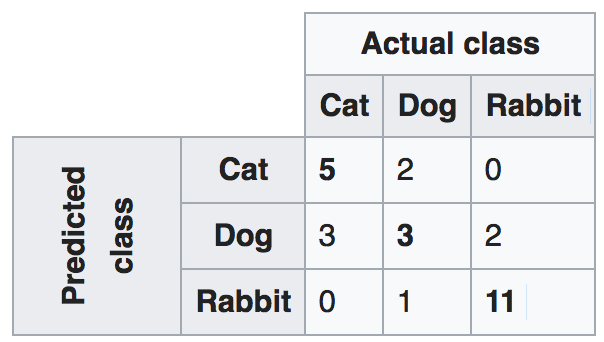

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

/var/folders/qx/5dmjvwj50ysf44p31147cjt40000gn/T/ipykernel_36755/3513133425.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix = np.zeros((10,10), np.int)


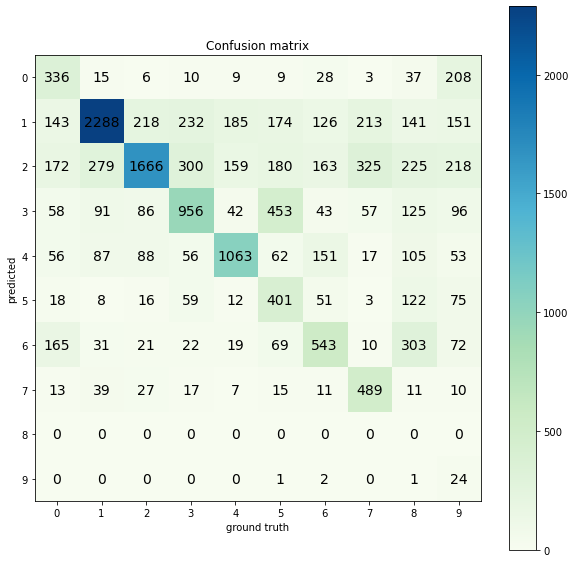

In [220]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for prediction, true_label in zip(predictions, ground_truth):
        confusion_matrix[int(prediction), int(true_label)] += 1

    
    
    # TODO: Implement filling the prediction matrix
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

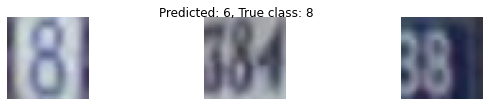

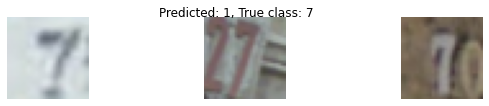

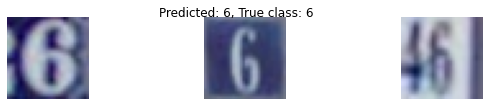

In [221]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indices = []
    for i, (prediction, true_label) in enumerate(zip(predictions, ground_truth)):
        if prediction == predicted_class and true_label == gt_class:
            indices.append(val_indices[i])
                                                 
    return visualize_images(indices, data, f'Predicted: {predicted_class}, True class: {gt_class}', 3)
    

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(6, 6, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [225]:
from torch.optim.lr_scheduler import StepLR
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size=2, gamma=1):    
    loss_history = []
    train_history = []
    val_history = []
    
    scheduler = StepLR(optimizer, step_size, gamma)
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    
        scheduler.step()
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x,y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    acc = float(correct_samples) / total_samples
        
    return acc

In [226]:
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [237]:
learning_rates = [1e-2, 1e-1]
weight_decays = [1e-1, 1e-2]
hidden_layer_size = [100, 150]
nums_epochs = [5]

best_val_acc = 0
best_model = None

for lr in learning_rates:
    for hls in hidden_layer_size:
        for weight_decay in weight_decays:
            for num_epochs in nums_epochs:
                print([lr, hls, weight_decay, num_epochs])
                
                nn_model = nn.Sequential(Flattener(),
                nn.Linear(3*32*32, hls),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hls),
                nn.Linear(hls, 100),
                nn.BatchNorm1d(100),
                nn.ReLU(inplace=True),            
                nn.Linear(100, 10)
             )
                nn_model.type(torch.FloatTensor)
                optimizer = optim.SGD(nn_model.parameters(), lr, weight_decay)
                loss = nn.CrossEntropyLoss()
                loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs, step_size=10, gamma=0.7)
                
                
                if best_val_acc < val_history[-1]:
                    best_model = nn_model
                    best_gyperparameters = [lr, hls, weight_decay, num_epochs]
                    



[0.01, 100, 0.1, 5]
Average loss: 1.528374, Train accuracy: 0.517370, Val accuracy: 0.639274
Average loss: 1.063250, Train accuracy: 0.676381, Val accuracy: 0.712579
Average loss: 0.911419, Train accuracy: 0.721018, Val accuracy: 0.743294
Average loss: 0.825035, Train accuracy: 0.745999, Val accuracy: 0.769436
Average loss: 0.758799, Train accuracy: 0.765997, Val accuracy: 0.784452
[0.01, 100, 0.01, 5]
Average loss: 1.542341, Train accuracy: 0.512149, Val accuracy: 0.612791
Average loss: 1.060433, Train accuracy: 0.681347, Val accuracy: 0.714627
Average loss: 0.908046, Train accuracy: 0.723339, Val accuracy: 0.745888
Average loss: 0.814261, Train accuracy: 0.749957, Val accuracy: 0.779059
Average loss: 0.758012, Train accuracy: 0.766287, Val accuracy: 0.725548
[0.01, 150, 0.1, 5]
Average loss: 1.497414, Train accuracy: 0.533478, Val accuracy: 0.683503
Average loss: 1.018016, Train accuracy: 0.691840, Val accuracy: 0.704252
Average loss: 0.862110, Train accuracy: 0.734191, Val accuracy:

In [246]:
lr, hls, weight_decay, num_epochs = best_gyperparameters

nn_model = nn.Sequential(Flattener(),
                nn.Linear(3*32*32, hls),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hls),
                nn.Linear(hls, 100),
                nn.BatchNorm1d(100),
                nn.ReLU(inplace=True),            
                nn.Linear(100, 10)
             )

num_epochs = 10

nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr, weight_decay)

loss = nn.CrossEntropyLoss()
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs, step_size=3, gamma=0.7)


Average loss: 1.300147, Train accuracy: 0.577654, Val accuracy: 0.695789
Average loss: 0.908755, Train accuracy: 0.716070, Val accuracy: 0.752508
Average loss: 0.778907, Train accuracy: 0.758779, Val accuracy: 0.762064
Average loss: 0.660156, Train accuracy: 0.797137, Val accuracy: 0.810798
Average loss: 0.625836, Train accuracy: 0.806743, Val accuracy: 0.812095
Average loss: 0.593160, Train accuracy: 0.816640, Val accuracy: 0.792847
Average loss: 0.533954, Train accuracy: 0.834130, Val accuracy: 0.828203
Average loss: 0.511938, Train accuracy: 0.843019, Val accuracy: 0.830046
Average loss: 0.500021, Train accuracy: 0.845408, Val accuracy: 0.819739
Average loss: 0.463204, Train accuracy: 0.856551, Val accuracy: 0.837281


In [173]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.5829
